In [ ]:
!python --version

Python 3.11.13


In [ ]:
!pip install tensorflow==2.18.0
!pip install git+https://github.com/tensorflow/addons.git

  Cloning https://github.com/tensorflow/addons.git to /tmp/pip-req-build-ojxrnbj2
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/addons.git /tmp/pip-req-build-ojxrnbj2
  Resolved https://github.com/tensorflow/addons.git to commit d208d752e98c310280938efa939117bf635a60a8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tensorflow-addons: filename=tensorflow_addons-0.23.0.dev0-cp311-cp311-linux_x86_64.whl size=512724 sha256=c05a0c218cb7b70a741fb89ee766828d8e7f2db054720a617b68d4c5ae038f53
  Stored in directory: /tmp/pip-ephem-wheel-cache-a4rsgrmy/wheels/e1/f2/35/c6cc7d42d768b878f0d700eebbfb82b69fbc16e16568ca3c95
Successfully built tensorflow-addons
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.4
    Uninstalling typeguard-4.4.4:
      Successfully uninstalled typeguard-4.4.4
ERROR: pip's dependency resolver does 

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa

print("TensorFlow version:", tf.__version__)
print("TensorFlow Addons version:", tfa.__version__)

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.18.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

TensorFlow version: 2.18.0
TensorFlow Addons version: 0.23.0-dev


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

  # Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:09<00:00, 220MB/s]
100% 2.29G/2.29G [00:09<00:00, 258MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
file_name = "/content/chest-xray-pneumonia.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import random

In [ ]:
healthy = [
    r'/content/chest_xray/chest_xray/test/NORMAL',
    r'/content/chest_xray/chest_xray/train/NORMAL',
]

pneumonia = [
    r'/content/chest_xray/chest_xray/test/PNEUMONIA',
    r'/content/chest_xray/chest_xray/train/PNEUMONIA',
]

In [ ]:
# Fonction pour charger les chemins des fichiers et les étiquettes
def load_data(paths, label):
    filepaths = []
    labels = []
    for path in paths:
        for file in os.listdir(path):
            filepaths.append(os.path.join(path, file))
            labels.append(label)
    return filepaths, labels

# Charger les données
healthy_files, healthy_labels = load_data(healthy, 0)  # 0 pour "Normal"
pneumonia_files, pneumonia_labels = load_data(pneumonia, 1)  # 1 pour "Pneumonia"

# Combiner les données
filepaths = healthy_files + pneumonia_files
labels = healthy_labels + pneumonia_labels

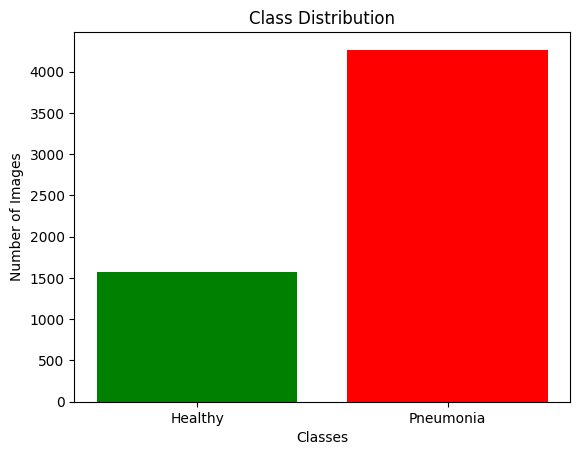

Number of Healthy images: 1576
Number of Pneumonia images: 4266


In [ ]:
# Count the number of images in each class
healthy_count = len(healthy_files)
pneumonia_count = len(pneumonia_files)

# Create a histogram
plt.bar(['Healthy', 'Pneumonia'], [healthy_count, pneumonia_count], color=['green', 'red'])
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()
# Afficher le nombre d'images dans chaque classe
print(f"Number of Healthy images: {healthy_count}")
print(f"Number of Pneumonia images: {pneumonia_count}")

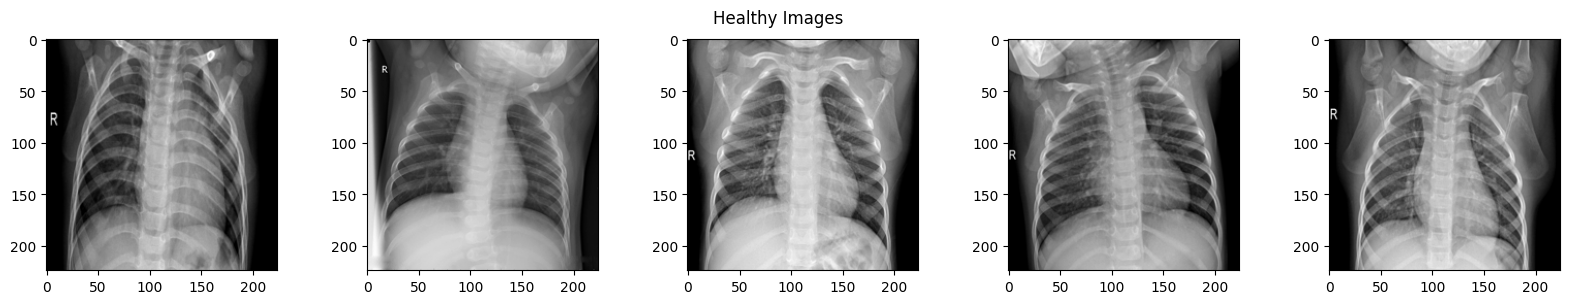

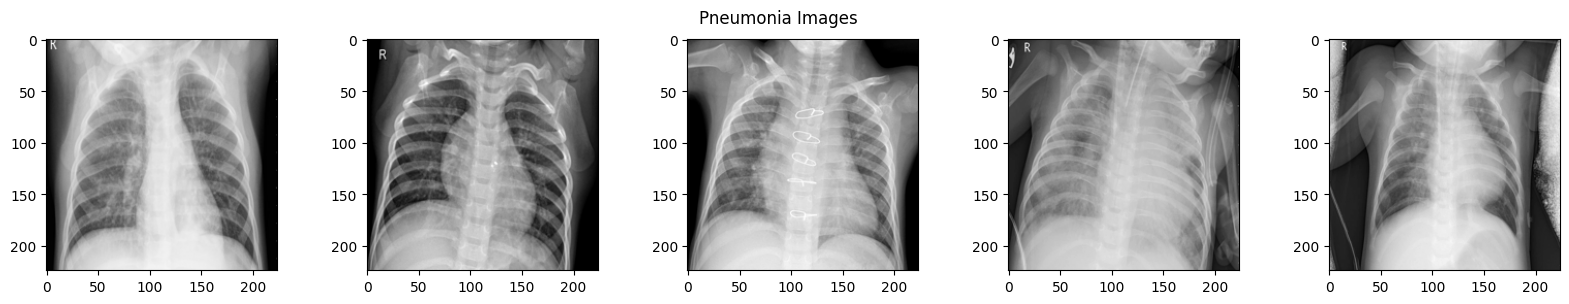

In [ ]:
def display_images(filepaths, title, num_images=5, img_size=(224, 224)):
    plt.figure(figsize=(20, 3))
    plt.suptitle(title)

    for i in range(num_images):
        img_path = random.choice(filepaths)
        img = Image.open(img_path).resize(img_size)  # Redimensionner l'image
        plt.subplot(1, num_images, i+1)
        plt.imshow(img, cmap='gray')#Affiche l’image en niveaux de gris.
        plt.axis('on')

    plt.show()
display_images(healthy_files, 'Healthy Images', img_size=(224, 224))
display_images(pneumonia_files, 'Pneumonia Images', img_size=(224, 224))

In [ ]:
train_files, test_files, train_labels, test_labels = train_test_split(filepaths, labels, test_size=0.2, random_state=42)

In [ ]:
print(len(train_files))
print(len(test_files))

4673
1169


In [ ]:
# Split the training data into training and validation sets
train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.1, random_state=42
)

In [ ]:
print(len(train_files))
print(len(test_files))
print(len(val_files))

4205
1169
468


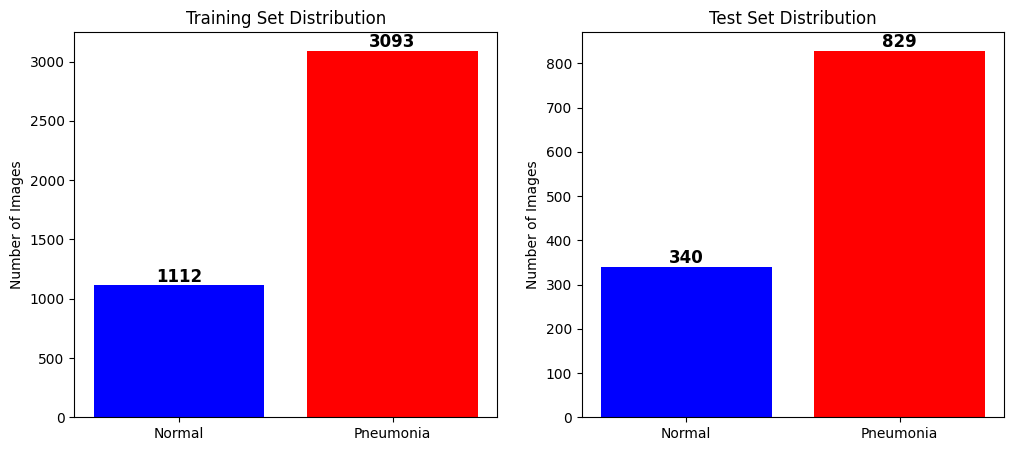

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert labels to NumPy array for easier processing
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Count the occurrences of each class (assuming 0 = Normal, 1 = Pneumonia)
train_counts = np.bincount(train_labels)
test_counts = np.bincount(test_labels)

# Define class names
class_names = ["Normal", "Pneumonia"]

# Plot histogram
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Training set histogram
bars_train = ax[0].bar(class_names, train_counts, color=['blue', 'red'])
ax[0].set_title("Training Set Distribution")
ax[0].set_ylabel("Number of Images")

# Test set histogram
bars_test = ax[1].bar(class_names, test_counts, color=['blue', 'red'])
ax[1].set_title("Test Set Distribution")
ax[1].set_ylabel("Number of Images")

# Add labels on top of the bars
for bar in bars_train:
    ax[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(bar.get_height())}',
               ha='center', va='bottom', fontsize=12, fontweight='bold')

for bar in bars_test:
    ax[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(bar.get_height())}',
               ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

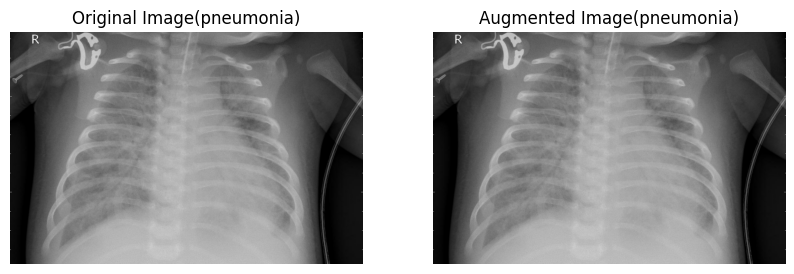

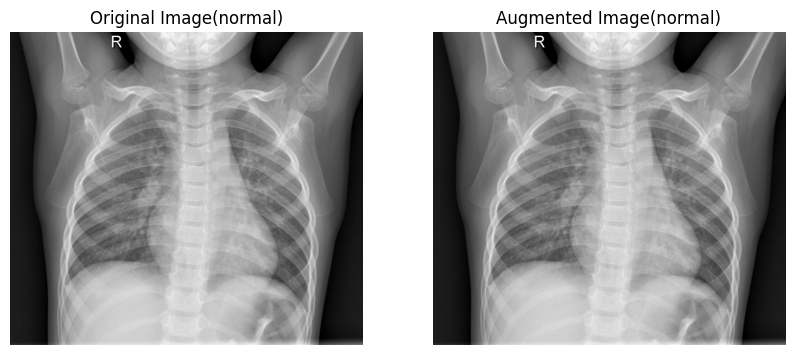

In [ ]:
#Flip horizontal aléatoire
image_path1 = '/content/chest_xray/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg'
image1 = tf.io.read_file(image_path1)  # Read the image file
image1 = tf.image.decode_jpeg(image1, channels=3)  # Decode the image into a tensor
left_right1 = tf.image.random_flip_left_right(image1)
image_path2 = '/content/chest_xray/chest_xray/train/NORMAL/IM-0115-0001.jpeg'
image2 = tf.io.read_file(image_path2)  # Read the image file
image2 = tf.image.decode_jpeg(image2, channels=3)  # Decode the image into a tensor
left_right2 = tf.image.random_flip_left_right(image2)


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image1.numpy().astype(int))  # Convert to NumPy array and display
plt.title('Original Image(pneumonia)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(left_right1.numpy().astype(int))  # Display rot1 instead of rot
plt.title('Augmented Image(pneumonia)')
plt.axis('off')

plt.show()
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image2.numpy().astype(int))  # Convert to NumPy array and display
plt.title('Original Image(normal)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(left_right2.numpy().astype(int))  # Convert to NumPy array and display
plt.title('Augmented Image(normal)')
plt.axis('off')

plt.show()

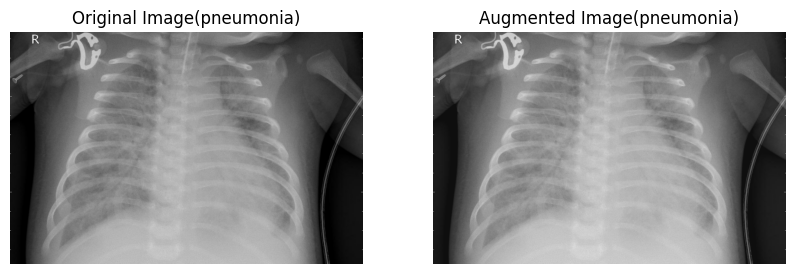

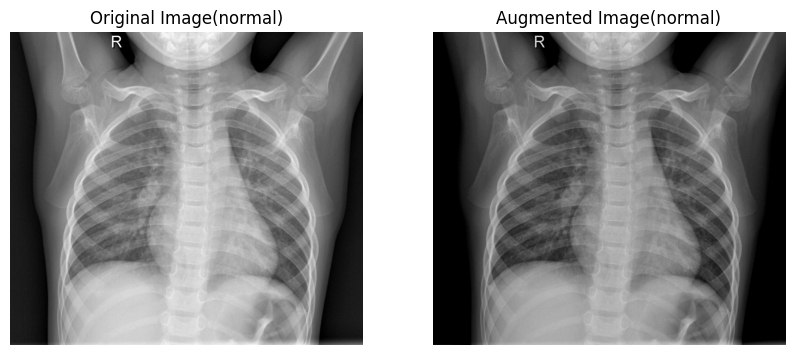

In [ ]:
#Modification de la luminosité
image_path1 = '/content/chest_xray/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg'
image1 = tf.io.read_file(image_path1)  # Read the image file
image1 = tf.image.decode_jpeg(image1, channels=3)  # Decode the image into a tensor
bright1 = tf.image.random_brightness(image1, max_delta=0.2)
image_path2 = '/content/chest_xray/chest_xray/train/NORMAL/IM-0115-0001.jpeg'
image2 = tf.io.read_file(image_path2)  # Read the image file
image2 = tf.image.decode_jpeg(image2, channels=3)  # Decode the image into a tensor
bright2 = tf.image.random_brightness(image2, max_delta=0.2)


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image1.numpy().astype(int))  # Convert to NumPy array and display
plt.title('Original Image(pneumonia)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(bright1.numpy().astype(int))  # Display rot1 instead of rot
plt.title('Augmented Image(pneumonia)')
plt.axis('off')

plt.show()
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image2.numpy().astype(int))  # Convert to NumPy array and display
plt.title('Original Image(normal)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(bright2.numpy().astype(int))  # Convert to NumPy array and display
plt.title('Augmented Image(normal)')
plt.axis('off')

plt.show()

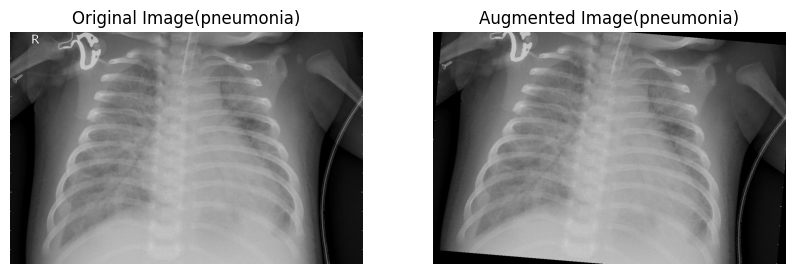

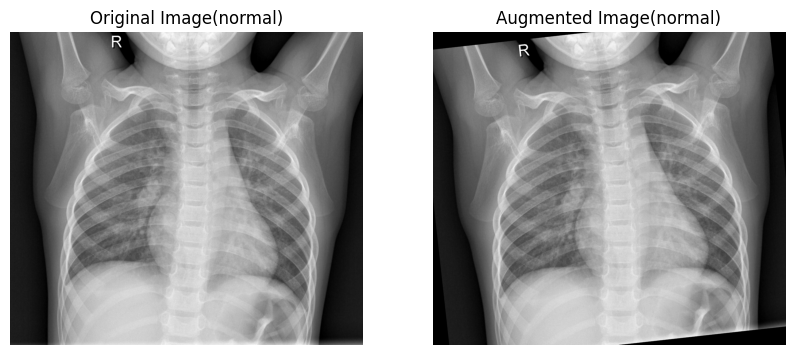

In [ ]:
#rotation
image_path1 = '/content/chest_xray/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg'
image1 = tf.io.read_file(image_path1)  # Read the image file
image1 = tf.image.decode_jpeg(image1, channels=3)  # Decode the image into a tensor
angles = tf.random.uniform(shape=[], minval=-0.2, maxval=0.2)  # Rotation entre -15° et 15° (en radians)
rot1 = tfa.image.rotate(image1, angles)
image_path2 = '/content/chest_xray/chest_xray/train/NORMAL/IM-0115-0001.jpeg'
image2 = tf.io.read_file(image_path2)  # Read the image file
image2 = tf.image.decode_jpeg(image2, channels=3)  # Decode the image into a tensor
angles = tf.random.uniform(shape=[], minval=-0.2, maxval=0.2)  # Rotation entre -10° et 10° (en radians)
rot2 = tfa.image.rotate(image2, angles)


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image1.numpy().astype(int))  # Convert to NumPy array and display
plt.title('Original Image(pneumonia)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rot1.numpy().astype(int))  # Display rot1 instead of rot
plt.title('Augmented Image(pneumonia)')
plt.axis('off')

plt.show()
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image2.numpy().astype(int))  # Convert to NumPy array and display
plt.title('Original Image(normal)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rot2.numpy().astype(int))  # Convert to NumPy array and display
plt.title('Augmented Image(normal)')
plt.axis('off')

plt.show()

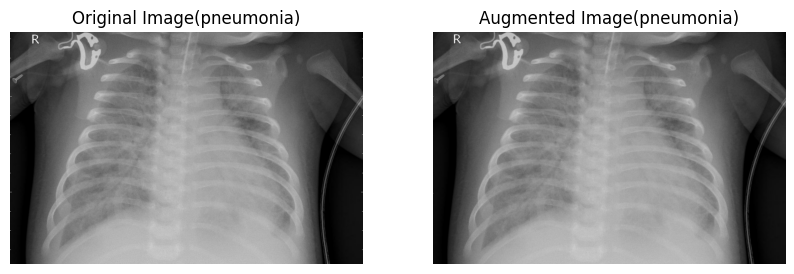

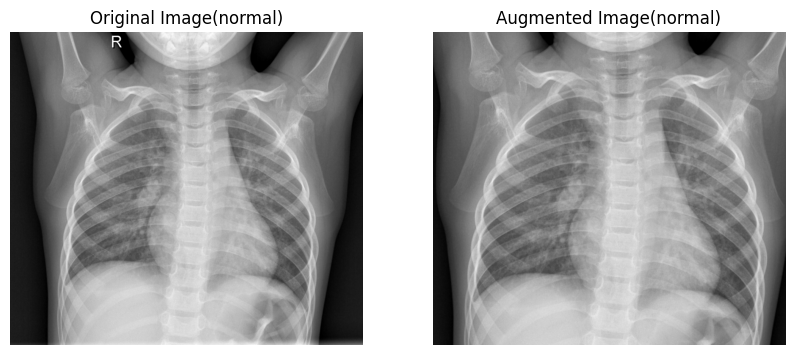

In [ ]:
#zoom
image_path1 = '/content/chest_xray/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg'
image1 = tf.io.read_file(image_path1)  # Read the image file
image1 = tf.image.decode_jpeg(image1, channels=3)  # Decode the image into a tensor
zoom_factor = tf.random.uniform(shape=[], minval=1.0, maxval=1.2)
original_shape = tf.shape(image1)
new_shape = tf.cast(tf.cast(original_shape[:2], tf.float32) * zoom_factor, tf.int32) # Select only height and width
image11 = tf.image.resize(image1, new_shape)
image12 = tf.image.random_crop(image11, original_shape)
image_path2 = '/content/chest_xray/chest_xray/train/NORMAL/IM-0115-0001.jpeg'
image2 = tf.io.read_file(image_path2)  # Read the image file
image2 = tf.image.decode_jpeg(image2, channels=3)  # Decode the image into a tensor
zoom_factor = tf.random.uniform(shape=[], minval=1.0, maxval=1.2)
original_shape = tf.shape(image2)
new_shape = tf.cast(tf.cast(original_shape[:2], tf.float32) * zoom_factor, tf.int32) # Select only height and width
image22 = tf.image.resize(image2, new_shape)
image13 = tf.image.random_crop(image22, original_shape)


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image1.numpy().astype(int))  # Convert to NumPy array and display
plt.title('Original Image(pneumonia)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image12.numpy().astype(int))  # Display rot1 instead of rot
plt.title('Augmented Image(pneumonia)')
plt.axis('off')

plt.show()
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image2.numpy().astype(int))  # Convert to NumPy array and display
plt.title('Original Image(normal)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image13.numpy().astype(int))  # Convert to NumPy array and display
plt.title('Augmented Image(normal)')
plt.axis('off')

plt.show()

In [ ]:
def create_dataset(filepaths, labels, batch_size=32, augment=False):
    def load_and_preprocess_image(filepath, label):
        try:
            image = tf.io.read_file(filepath)
            image = tf.image.decode_jpeg(image, channels=3)

            image = tf.image.resize(image, [224, 224])
            image = image / 255.0  # Normalisation
            return image, label
        except tf.errors.InvalidArgumentError:
            # Handle cases where image decoding fails
            print(f"Skipping invalid image file: {filepath.numpy()}")
            return tf.constant([], dtype=tf.float32), tf.constant([], dtype=tf.int32) # Return empty tensors

    # Filter out .DS_Store files
    filtered_filepaths = [f for f in filepaths if not f.endswith('.DS_Store')]
    filtered_labels = [labels[i] for i, f in enumerate(filepaths) if not f.endswith('.DS_Store')]


    dataset = tf.data.Dataset.from_tensor_slices((filtered_filepaths, filtered_labels))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.filter(lambda image, label: tf.size(image) > 0) # Filter out empty tensors


    if augment:
        def augment_image(image, label):
            angles = tf.random.uniform(shape=[], minval=-0.2, maxval=0.2)
            image = tfa.image.rotate(image, angles)
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_brightness(image, max_delta=0.2)
            # Zoom (20% zoom in)
            zoom_factor = tf.random.uniform(shape=[], minval=1.0, maxval=1.2)
            original_shape = tf.shape(image)
            new_shape = tf.cast(tf.cast(original_shape[:2], tf.float32) * zoom_factor, tf.int32) # Select only height and width
            image = tf.image.resize(image, new_shape)
            image = tf.image.random_crop(image, original_shape)
            image = tf.clip_by_value(image, 0.0, 1.0)
            # Return the image and label, regardless of augmentation
            return image, label
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)


    dataset = dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Créer les datasets
train_dataset = create_dataset(train_files, train_labels, augment=True)
test_dataset = create_dataset(test_files, test_labels)
val_dataset = create_dataset(val_files, val_labels)

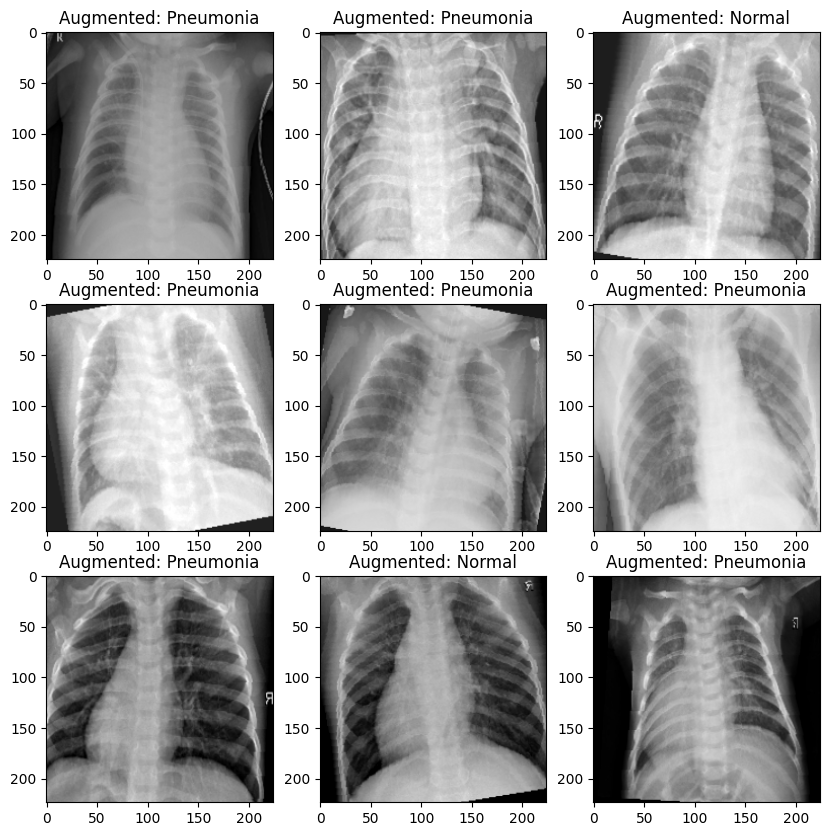

In [ ]:
import matplotlib.pyplot as plt

# Dictionnaire de correspondance des labels pour les deux classes
label_dict = {0: "Normal", 1: "Pneumonia"}

# Prendre un batch d'images du dataset
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(images))):  # Afficher jusqu'à 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Augmented: {label_dict[labels[i].numpy()]}")
        plt.axis("on")
    plt.show()

In [ ]:
from PIL import Image

def find_corrupted_images(filepaths):
    corrupted_files = []
    print("Checking for corrupted images...")
    for filepath in filepaths:
        try:
            img = Image.open(filepath)
            img.verify() # Verify that the file is an image
            img.close() # Close the image to release resources
        except Exception as e:
            corrupted_files.append(filepath)
            print(f"Corrupted or invalid image file found: {filepath} - Error: {e}")
    print("Finished checking.")
    return corrupted_files

# Check train, validation, and test sets
corrupted_train = find_corrupted_images(train_files)
corrupted_val = find_corrupted_images(val_files)
corrupted_test = find_corrupted_images(test_files)

print(f"\nNumber of corrupted files in training set: {len(corrupted_train)}")
print(f"Number of corrupted files in validation set: {len(corrupted_val)}")
print(f"Number of corrupted files in test set: {len(corrupted_test)}")

# You can print the list of corrupted files if needed
# print("\nCorrupted training files:", corrupted_train)
# print("Corrupted validation files:", corrupted_val)
# print("Corrupted test files:", corrupted_test)

Checking for corrupted images...
Corrupted or invalid image file found: /content/chest_xray/chest_xray/train/NORMAL/.DS_Store - Error: cannot identify image file '/content/chest_xray/chest_xray/train/NORMAL/.DS_Store'
Corrupted or invalid image file found: /content/chest_xray/chest_xray/train/PNEUMONIA/.DS_Store - Error: cannot identify image file '/content/chest_xray/chest_xray/train/PNEUMONIA/.DS_Store'
Finished checking.
Checking for corrupted images...
Finished checking.
Checking for corrupted images...
Finished checking.

Number of corrupted files in training set: 2
Number of corrupted files in validation set: 0
Number of corrupted files in test set: 0


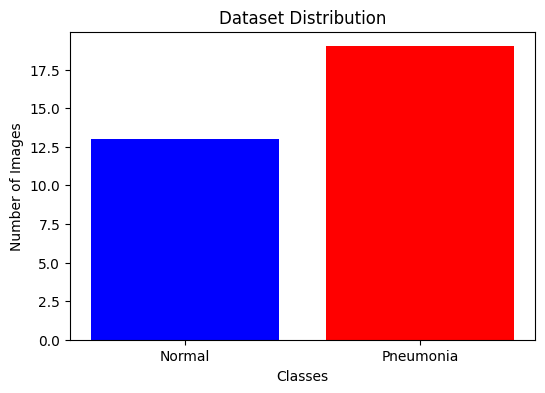

In [ ]:
# Plot the distribution of the dataset
import matplotlib.pyplot as plt
import numpy as np

# Assuming labels are 0 for Normal and 1 for Pneumonia
class_counts = np.bincount(labels)
class_names = ["Normal", "Pneumonia"]

plt.figure(figsize=(6, 4))
plt.bar(class_names, class_counts, color=['blue', 'red'])
plt.title('Dataset Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Charger un modèle pré-entraîné (VGG19)
base_model = VGG19(include_top=False, input_shape=(224,224,3), weights='imagenet')

# Dégeler partiellement le modèle (ex : les 10 dernières couches)
for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Ajouter des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)


# Créer le modèle final
model = Model(inputs=base_model.input, outputs=predictions)

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Afficher le résumé du modèle
model.summary()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,156,226 (76.89 MB)

 Trainable params: 17,830,658 (68.02 MB)

 Non-trainable params: 2,325,568 (8.87 MB)

In [ ]:
for layer in model.layers:
   print(layer, layer.trainable== True)

<InputLayer name=input_layer, built=True> False
<Conv2D name=block1_conv1, built=True> False
<Conv2D name=block1_conv2, built=True> False
<MaxPooling2D name=block1_pool, built=True> False
<Conv2D name=block2_conv1, built=True> False
<Conv2D name=block2_conv2, built=True> False
<MaxPooling2D name=block2_pool, built=True> False
<Conv2D name=block3_conv1, built=True> False
<Conv2D name=block3_conv2, built=True> False
<Conv2D name=block3_conv3, built=True> False
<Conv2D name=block3_conv4, built=True> False
<MaxPooling2D name=block3_pool, built=True> False
<Conv2D name=block4_conv1, built=True> True
<Conv2D name=block4_conv2, built=True> True
<Conv2D name=block4_conv3, built=True> True
<Conv2D name=block4_conv4, built=True> True
<MaxPooling2D name=block4_pool, built=True> True
<Conv2D name=block5_conv1, built=True> True
<Conv2D name=block5_conv2, built=True> True
<Conv2D name=block5_conv3, built=True> True
<Conv2D name=block5_conv4, built=True> True
<MaxPooling2D name=block5_pool, built=Tru

**Exercice** : Écrivez un code TensorFlow/Keras pour entraîner un modèle CNN (VGG19) sur le jeu de données d’images (train_files et val_dataset) en utilisant des callbacks afin de :

-Arrêter automatiquement l’entraînement lorsque la performance sur les données de validation cesse de s’améliorer.

-Sauvegarder uniquement la version du modèle ayant obtenu la meilleure performance sur la validation.

Instructions :

- Utilisez EarlyStopping pour surveiller la perte de validation (val_loss) et restaurer les meilleurs poids.

- Utilisez ModelCheckpoint pour sauvegarder le meilleur modèle dans un fichier nommé 'best_modelVGG19.keras'.

- Entraînez le modèle sur un maximum de 50 époques avec les callbacks activés.

# VGG19 model Training

In [ ]:
#  --- training VGG19 model with Callbacks ---

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#  Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss',           # Monitor validation loss
    patience=5,                   # Stop after 5 epochs with no improvement
    restore_best_weights=True,    # Restore best model weights
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='best_modelVGG19.keras',  # File to save best model
    monitor='val_loss',                # Watch validation loss
    save_best_only=True,               # Save only best epoch
    save_weights_only=False,           # Save full model (architecture + weights)
    verbose=1
)

#  Recompile model (recommended before retraining)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#  Train the model again
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stop, checkpoint],
    verbose=1
)




Epoch 1/50
    132/Unknown 87s 466ms/step - accuracy: 0.7912 - loss: 0.4412

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.46321, saving model to best_modelVGG19.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 106s 611ms/step - accuracy: 0.7917 - loss: 0.4404 - val_accuracy: 0.7735 - val_loss: 0.4632
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.9159 - loss: 0.2267
Epoch 2: val_loss did not improve from 0.46321
132/132 ━━━━━━━━━━━━━━━━━━━━ 47s 352ms/step - accuracy: 0.9159 - loss: 0.2265 - val_accuracy: 0.7457 - val_loss: 0.5507
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9373 - loss: 0.1752
Epoch 3: val_loss did not improve from 0.46321
132/132 ━━━━━━━━━━━━━━━━━━━━ 46s 348ms/step - accuracy: 0.9374 - loss: 0.1751 - val_accuracy: 0.7436 - val_loss: 0.5392
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.9441 - loss: 0.1563
Epoch 4: val_loss improved from 0.46321 to 0.32078, saving model to best_modelVGG19.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 48s 363ms/step - accuracy: 0.9441 - loss: 0.1563 - val_accuracy: 0.8269 - v

In [ ]:
#Écrivez le code permettant de recharger un modèle Keras déjà entraîné et sauvegardé.
from tensorflow.keras.models import load_model

# Recharger le modèle sauvegardé
loaded_model = load_model('best_modelVGG19.keras')

print("Modèle rechargé avec succès !")

Modèle rechargé avec succès !


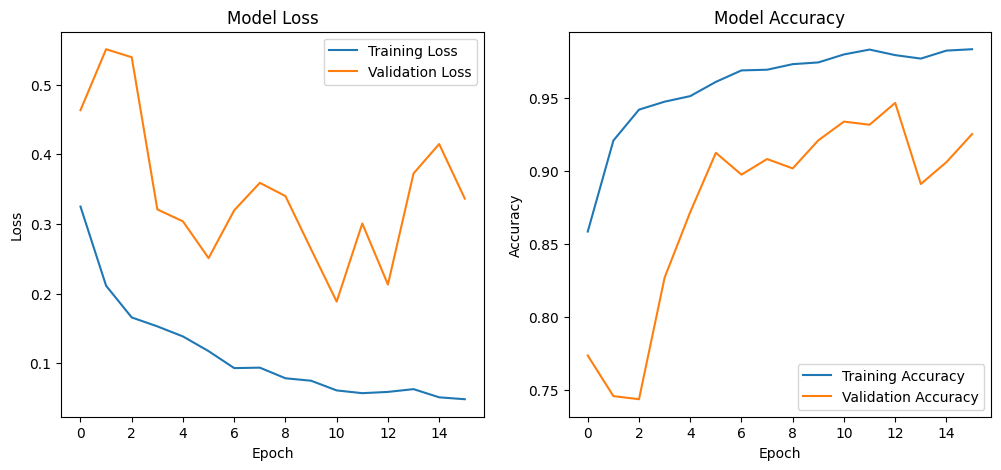

In [ ]:
#  Plot training curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Evaluate the model on the validation dataset
print("Evaluating model on validation dataset...")
loss, accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Get true labels from the validation dataset
true_labels_val = np.concatenate([y for x, y in val_dataset], axis=0)

# Get predicted labels from the model for the validation dataset
predictions_val = model.predict(val_dataset)
predicted_labels_val = np.argmax(predictions_val, axis=1)

# Afficher le rapport de classification avec 4 chiffres après la virgule
print("\nClassification Report on Validation Data:")
print(classification_report(true_labels_val, predicted_labels_val, target_names=['Normal', 'Pneumonia'], digits=4))

# Calculer et afficher les métriques globales
accuracy_val = accuracy_score(true_labels_val, predicted_labels_val)
precision_val = precision_score(true_labels_val, predicted_labels_val)
recall_val = recall_score(true_labels_val, predicted_labels_val)
f1_val = f1_score(true_labels_val, predicted_labels_val)

print("\nGlobal Metrics on Validation Data:")
print(f"Accuracy: {accuracy_val:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"Recall: {recall_val:.4f}")
print(f"F1 Score: {f1_val:.4f}")

Evaluating model on validation dataset...
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.9368 - loss: 0.1975
Validation Loss: 0.1884
Validation Accuracy: 0.9338
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step

Classification Report on Validation Data:
              precision    recall  f1-score   support

      Normal     0.8039    0.9919    0.8881       124
   Pneumonia     0.9968    0.9128    0.9530       344

    accuracy                         0.9338       468
   macro avg     0.9004    0.9524    0.9205       468
weighted avg     0.9457    0.9338    0.9358       468


Global Metrics on Validation Data:
Accuracy: 0.9338
Precision: 0.9968
Recall: 0.9128
F1 Score: 0.9530


37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 371ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


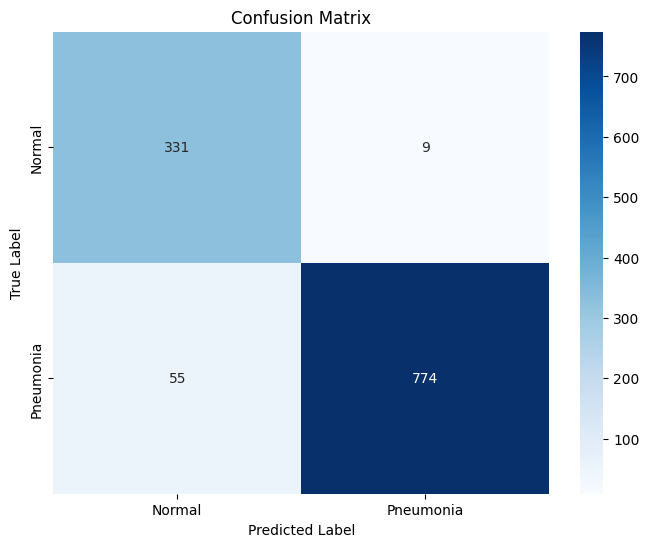

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get true labels from the test dataset
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Get predicted labels from the model
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#Exploiter différentes méthodes de XAI -- se référer aux liens Github donnés dans le support de cours

In [ ]:
pip install lime scikit-image


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 26.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=1671009f9b2f00729a8406a318ca43b1280a4eb36f34d159f8ea2d33a2f59cf9
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from skimage.segmentation import mark_boundaries
from lime import lime_image

In [ ]:
# Load your trained model (if not already loaded)
from tensorflow.keras.models import load_model
model = load_model('best_modelVGG19.keras')

# Define image preprocessing (adjust input size to your model)
IMG_SIZE = (224, 224)   # for VGG19

In [ ]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=IMG_SIZE)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = x / 255.0        # normalize if your model was trained on [0,1]
        out.append(x)
    return np.vstack(out)


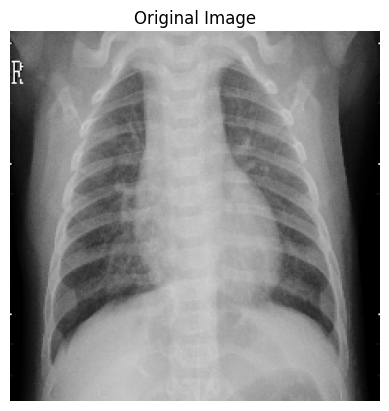

In [ ]:
# Path to the image you want to explain
img_path = '/content/chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg'

# Preprocess the image
images = transform_img_fn([img_path])
plt.imshow(images[0])
plt.title("Original Image")
plt.axis('off')
plt.show()

In [ ]:
# --- Prediction ---
preds = model.predict(images)
pred_label = np.argmax(preds[0])
print("Predicted class:", pred_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: 1


In [ ]:
# --- LIME Explanation ---
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    images[0].astype('double'),
    model.predict,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

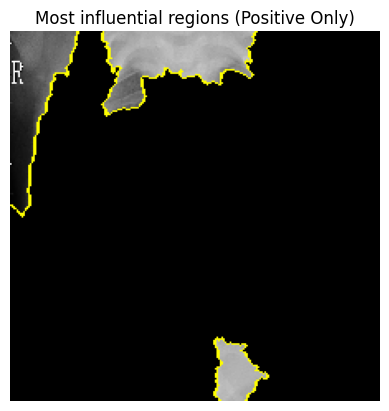

In [ ]:
# --- Visualizations ---
# 1️⃣ Only the most positive superpixels (supporting the prediction)
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=True
)
plt.imshow(mark_boundaries(temp, mask))
plt.title("Most influential regions (Positive Only)")
plt.axis('off')
plt.show()

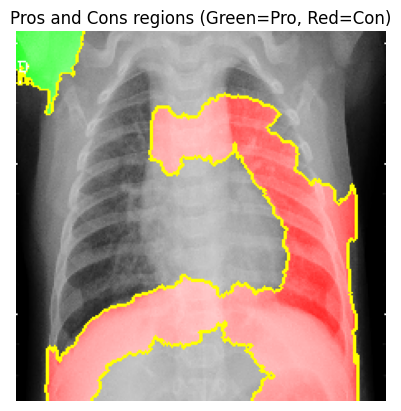

In [ ]:
# 2️⃣ Positive and negative contributions (green=pro, red=con)
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    num_features=10,
    hide_rest=False
)
plt.imshow(mark_boundaries(temp, mask))
plt.title("Pros and Cons regions (Green=Pro, Red=Con)")
plt.axis('off')
plt.show()

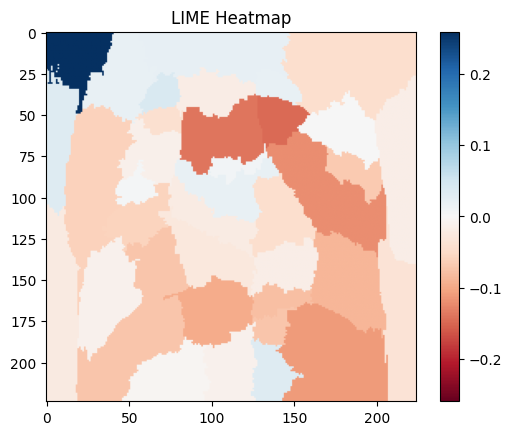

In [ ]:
# 3️⃣ Heatmap visualization
ind = explanation.top_labels[0]
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

plt.imshow(heatmap, cmap='RdBu', vmin=-heatmap.max(), vmax=heatmap.max())
plt.title("LIME Heatmap")
plt.colorbar()
plt.show()

In [ ]:
#Tester d'autres modèles de deep learning ViT, CNN... en utilisant le fine tuning